In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
fx_df = pd.read_csv(r'E:\study\22fall\hf\data\NR4\FX.csv')
fx_df.loc[:,'range'] = fx_df.loc[:,'High']-fx_df.loc[:,'Low']
range_df = fx_df.loc[:,['Date','ticker','range']].pivot_table(index = 'Date',columns='ticker',values='range')

In [3]:
high_df = fx_df.loc[:,['Date','ticker','High']].pivot_table(index = 'Date',columns='ticker',values='High')
low_df = fx_df.loc[:,['Date','ticker','Low']].pivot_table(index = 'Date',columns='ticker',values='Low')

In [4]:
high_ibar_df = high_df-high_df.shift(1)
high_ibar_df = high_ibar_df.where(high_ibar_df<0)*0+1
low_ibar_df = low_df-low_df.shift(1)
low_ibar_df = low_ibar_df.where(low_ibar_df<0)*0+1
ibar_df = low_ibar_df*high_ibar_df

In [5]:
ibar_df.fillna(0,inplace=True)
ibar_df = ibar_df.stack().reset_index()

In [6]:
# NR period parameter
period_int = 4
accu_min_df = range_df.rolling(window=period_int-1).min().shift(1)
accu_min_stack_df = accu_min_df.stack()
accu_min_stack_df = accu_min_stack_df.reset_index()

In [7]:
fx_nr_df = pd.merge(fx_df,accu_min_stack_df,left_on=['Date','ticker'],right_on =['Date','ticker'])
fx_nr_df = pd.merge(fx_nr_df,ibar_df,left_on=['Date','ticker'],right_on =['Date','ticker'])
fx_nr_df.columns = fx_nr_df.columns[:-2].tolist()+['min_range','ibar']
fx_nr_df.loc[:,'NR4_Ibar'] = fx_nr_df.loc[:,'range']-fx_nr_df.loc[:,'min_range']
fx_nr_df.loc[:,'NR4_Ibar'] = fx_nr_df.loc[:,['NR4_Ibar']].where(fx_nr_df.loc[:,'NR4_Ibar']>0)*0
fx_nr_df.loc[:,'NR4_Ibar'] = fx_nr_df.loc[:,['NR4_Ibar']].fillna(1)
fx_nr_df.loc[:,'NR4_Ibar'] *= fx_nr_df.loc[:,'ibar']

In [8]:
#select specific FX
fx_sp_df =fx_nr_df.where(fx_nr_df['ticker']=='EURUSD=X').dropna(axis=0)

In [9]:
#breakout
fx_sp_df.loc[:,'last_NR4Ibar'] = fx_sp_df.loc[:,'NR4_Ibar'].shift(1)
fx_sp_df.loc[:,'high_break'] = fx_sp_df.loc[:,'High']-fx_sp_df.loc[:,'High'].shift(1)
fx_sp_df.loc[:,['high_break']] = fx_sp_df.loc[:,['high_break']].where(fx_sp_df.loc[:,['high_break']]<=0)*0
fx_sp_df.loc[:,'high_break'].fillna(1,inplace=True)
fx_sp_df.loc[:,'low_break'] = fx_sp_df.loc[:,'Low']-fx_sp_df.loc[:,'Low'].shift(1)
fx_sp_df.loc[:,['low_break']] = fx_sp_df.loc[:,['low_break']].where(fx_sp_df.loc[:,['low_break']]>=0)*0
fx_sp_df.loc[:,'low_break'].fillna(-1,inplace=True)
fx_sp_df.loc[:,'short_sig'] = fx_sp_df.loc[:,'low_break']*fx_sp_df.loc[:,'last_NR4Ibar']
fx_sp_df.loc[:,'long_sig'] = fx_sp_df.loc[:,'high_break']*fx_sp_df.loc[:,'last_NR4Ibar']
fx_sp_df.loc[:,'sig'] = fx_sp_df.loc[:,'short_sig']+fx_sp_df.loc[:,'long_sig']

# On Day 5, If price move above NR4 bar's high, Long at the high price; If price falls below NR4's low, short at NR4's low; Exit the trade at that days's close(or next k days's close)
fx_sp_df.loc[:,'last_high'] = fx_sp_df.loc[:,'High'].shift(1)
fx_sp_df.loc[:,'last_low'] = fx_sp_df.loc[:,'Low'].shift(1)
fx_sp_df.loc[:,'last_high'] = fx_sp_df.loc[:,'last_high']*fx_sp_df.loc[:,'sig']
fx_sp_df.loc[:,'last_high'] = fx_sp_df.loc[:,'last_high'].where(fx_sp_df.loc[:,'last_high']>0).fillna(0)
fx_sp_df.loc[:,'last_low'] = fx_sp_df.loc[:,'last_low']*fx_sp_df.loc[:,'sig']
fx_sp_df.loc[:,'last_low'] = -fx_sp_df.loc[:,'last_low'].where(fx_sp_df.loc[:,'last_low']<0).fillna(0)
fx_sp_df.loc[:,'execute_price'] = fx_sp_df.loc[:,'last_high'].values+fx_sp_df.loc[:,'last_low'].values

In [10]:
#stop price
fx_sp_df.loc[:,'last_high_stop'] = fx_sp_df.loc[:,'High'].shift(1)
fx_sp_df.loc[:,'last_low_stop'] = fx_sp_df.loc[:,'Low'].shift(1)

In [11]:
# exit at the breakout bar
low_exit_ser = fx_sp_df.where((fx_sp_df.loc[:,'sig']>0)&
                             (fx_sp_df.loc[:,'Close']<fx_sp_df.loc[:,'last_low_stop'])).loc[:,'last_low_stop'].fillna(0)
high_exit_ser = fx_sp_df.where((fx_sp_df.loc[:,'sig']<0) &
                              (fx_sp_df.loc[:,'Close']>fx_sp_df.loc[:,'last_high_stop'])).loc[:,'last_high_stop'].fillna(0)
exit_p_ser = low_exit_ser+high_exit_ser
no_stop_array = np.where(exit_p_ser==0)[0]
exit_p_df = fx_sp_df[['Close']].iloc[no_stop_array.tolist(),:]
fx_sp_df.loc[:,'exit_price'] = exit_p_df.iloc[:,0].tolist()

In [ ]:
# exit at the bar 6 day after breakout bar
fx_sp_df.loc[:,'Close_6D'] = fx_sp_df.loc[:,'Close'].shift(-6)
low_exit_ser = fx_sp_df.where((fx_sp_df.loc[:,'sig']>0)&
                             (fx_sp_df.loc[:,'Close_6D']<fx_sp_df.loc[:,'last_low_stop'])).loc[:,'last_low_stop'].fillna(0)
high_exit_ser = fx_sp_df.where((fx_sp_df.loc[:,'sig']<0) &
                              (fx_sp_df.loc[:,'Close_6D']>fx_sp_df.loc[:,'last_high_stop'])).loc[:,'last_high_stop'].fillna(0)
exit_p_ser = low_exit_ser+high_exit_ser
no_stop_array = np.where(exit_p_ser==0)[0]
exit_p_ser.iloc[no_stop_array.tolist()] = fx_sp_df[['Close_6D']].iloc[no_stop_array.tolist(),0].tolist()
fx_sp_df.loc[:,'exit_price_6D'] = exit_p_ser.tolist()

In [24]:
# exit at the bar 3 day after breakout bar
fx_sp_df.loc[:,'Close_3D'] = fx_sp_df.loc[:,'Close'].shift(-3)
low_exit_ser = fx_sp_df.where((fx_sp_df.loc[:,'sig']>0)&
                             (fx_sp_df.loc[:,'Close_3D']<fx_sp_df.loc[:,'last_low_stop'])).loc[:,'last_low_stop'].fillna(0)
high_exit_ser = fx_sp_df.where((fx_sp_df.loc[:,'sig']<0) &
                              (fx_sp_df.loc[:,'Close_3D']>fx_sp_df.loc[:,'last_high_stop'])).loc[:,'last_high_stop'].fillna(0)
exit_p_ser = low_exit_ser+high_exit_ser
no_stop_array = np.where(exit_p_ser==0)[0]
exit_p_ser.iloc[no_stop_array.tolist()] = fx_sp_df[['Close_3D']].iloc[no_stop_array.tolist(),0].tolist()
fx_sp_df.loc[:,'exit_price_3D'] = exit_p_ser.tolist()

#simulation part

In [25]:
# Dont consider fees, exit at day5
simu_df = fx_sp_df.copy()
simu_df.loc[:,'ror_0d'] = simu_df.loc[:,'sig']*\
                          (simu_df.loc[:,'exit_price']-simu_df.loc[:,'execute_price'])/simu_df.loc[:,'execute_price']
simu_df.loc[:,'ror_6d'] = simu_df.loc[:,'sig']*\
                          (simu_df.loc[:,'exit_price_6D']-simu_df.loc[:,'execute_price'])/simu_df.loc[:,'execute_price']
simu_df.loc[:,'ror_3d'] = simu_df.loc[:,'sig']*\
                          (simu_df.loc[:,'exit_price_3D']-simu_df.loc[:,'execute_price'])/simu_df.loc[:,'execute_price']
#simu_df.dropna(inplace=True)

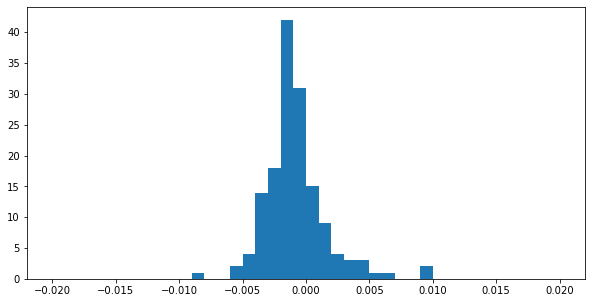

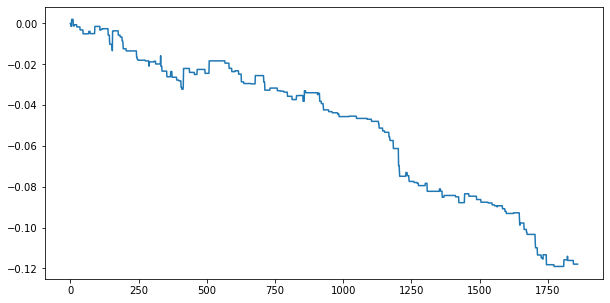

In [33]:
#ror_distribution
simu_ror_df = simu_df.loc[:,['ror_0d']].dropna(axis=0)
plt.figure(figsize=(10,5))
plt.hist(simu_ror_df,bins=40,range = (-0.02,0.02))
plt.show()
simu_ror_array = simu_df.loc[:,['ror_0d']].fillna(0).values
accu_ret_array = np.exp(np.add.accumulate(np.log(simu_ror_array+1)))-1
plt.figure(figsize=(10,5))
plt.plot(accu_ret_array)
plt.show()

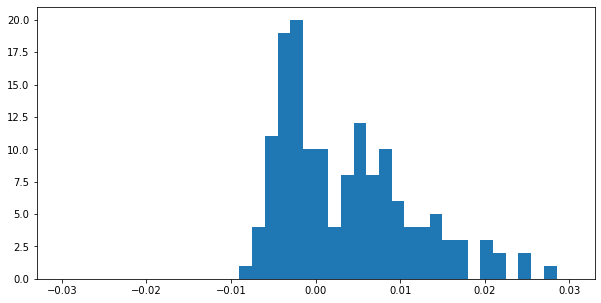

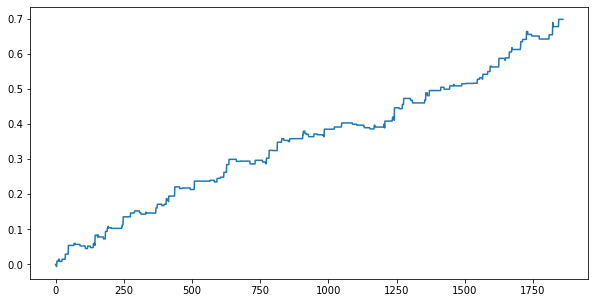

In [34]:
simu_ror_df = simu_df.loc[:,['ror_6d']].dropna(axis=0)
plt.figure(figsize=(10,5))
plt.hist(simu_ror_df,bins=40,range = (-0.03,0.03))
plt.show()
simu_ror_array = simu_df.loc[:,['ror_6d']].fillna(0).values
accu_ret_array = np.exp(np.add.accumulate(np.log(simu_ror_array+1)))-1
plt.figure(figsize=(10,5))
plt.plot(accu_ret_array)
plt.show()

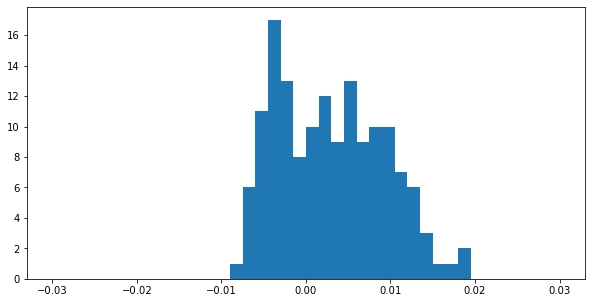

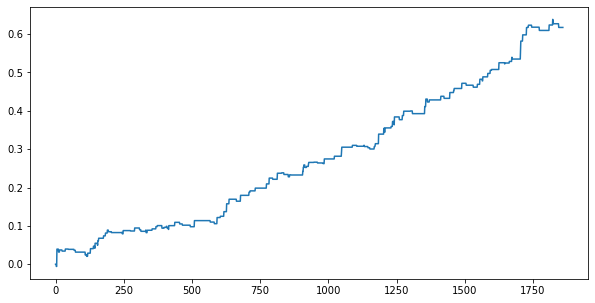

In [35]:
simu_ror_df = simu_df.loc[:,['ror_3d']].dropna(axis=0)
plt.figure(figsize=(10,5))
plt.hist(simu_ror_df,bins=40,range = (-0.03,0.03))
plt.show()
simu_ror_array = simu_df.loc[:,['ror_3d']].fillna(0).values
accu_ret_array = np.exp(np.add.accumulate(np.log(simu_ror_array+1)))-1
plt.figure(figsize=(10,5))
plt.plot(accu_ret_array)
plt.show()